# DSCI 417 – Project 01
## Analysis of NASA Server Logs
**Lauren Forti**

## Part A: Set up Environment
Setup the environment, starting with imports.

In [0]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

Create the SparkSession and SparkContext objects.

In [0]:
# create objects
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

## Part B: Load and Process Data
Load the data, check the first few elements, and process the data. Start by loading in the data and printing the number of elements.

In [0]:
# read in dataset as RDD
nasa_raw = sc.textFile('/FileStore/tables/NASA_server_logs_Aug_1995.txt')

# output # of elements
print('Number of elements:', nasa_raw.count())

Number of elements: 1569888

Display the first few elements of the RDD.

In [0]:
# output first 10 rows
for row in nasa_raw.take(10):
  print(row)

in24.inetnebr.com [01/Aug/1995:00:00:01] "GET /shuttle/missions/sts-68/news/sts-68-mcc-05.txt" 200 1839
uplherc.upl.com [01/Aug/1995:00:00:07] "GET /" 304 0
uplherc.upl.com [01/Aug/1995:00:00:08] "GET /images/ksclogo-medium.gif" 304 0
uplherc.upl.com [01/Aug/1995:00:00:08] "GET /images/MOSAIC-logosmall.gif" 304 0
uplherc.upl.com [01/Aug/1995:00:00:08] "GET /images/USA-logosmall.gif" 304 0
ix-esc-ca2-07.ix.netcom.com [01/Aug/1995:00:00:09] "GET /images/launch-logo.gif" 200 1713
uplherc.upl.com [01/Aug/1995:00:00:10] "GET /images/WORLD-logosmall.gif" 304 0
slppp6.intermind.net [01/Aug/1995:00:00:10] "GET /history/skylab/skylab.html" 200 1687
piweba4y.prodigy.com [01/Aug/1995:00:00:10] "GET /images/launchmedium.gif" 200 11853
slppp6.intermind.net [01/Aug/1995:00:00:11] "GET /history/skylab/skylab-small.gif" 200 9202

Process each line of server information by removing the double quotes, tokenizing the strings,
replacing the hyphens that appear for the number of bytes with zeros, and coercing the values into appropriate
datatypes.

In [0]:
def process_row(row):
  # replace double quotes w/ empty strings
  row = row.replace('"', '')
  # tokenize the string on space chars
  tokens = row.split(' ')
  # change hyphens to 0
  if tokens[5] == '-':
    tokens[5] = 0
  # return list of tokens
  return [tokens[0], tokens[1], tokens[2], tokens[3], tokens[4], int(tokens[5])]

# process each row
nasa = (
  nasa_raw
  .map(process_row)
)

# persist nasa RDD to memory
nasa.persist()

# output first 10 elements
for row in nasa.take(10):
  print(row)

['in24.inetnebr.com', '[01/Aug/1995:00:00:01]', 'GET', '/shuttle/missions/sts-68/news/sts-68-mcc-05.txt', '200', 1839]
['uplherc.upl.com', '[01/Aug/1995:00:00:07]', 'GET', '/', '304', 0]
['uplherc.upl.com', '[01/Aug/1995:00:00:08]', 'GET', '/images/ksclogo-medium.gif', '304', 0]
['uplherc.upl.com', '[01/Aug/1995:00:00:08]', 'GET', '/images/MOSAIC-logosmall.gif', '304', 0]
['uplherc.upl.com', '[01/Aug/1995:00:00:08]', 'GET', '/images/USA-logosmall.gif', '304', 0]
['ix-esc-ca2-07.ix.netcom.com', '[01/Aug/1995:00:00:09]', 'GET', '/images/launch-logo.gif', '200', 1713]
['uplherc.upl.com', '[01/Aug/1995:00:00:10]', 'GET', '/images/WORLD-logosmall.gif', '304', 0]
['slppp6.intermind.net', '[01/Aug/1995:00:00:10]', 'GET', '/history/skylab/skylab.html', '200', 1687]
['piweba4y.prodigy.com', '[01/Aug/1995:00:00:10]', 'GET', '/images/launchmedium.gif', '200', 11853]
['slppp6.intermind.net', '[01/Aug/1995:00:00:11]', 'GET', '/history/skylab/skylab-small.gif', '200', 9202]

## Part C: Most Requested Resources
Determine which resources were requested most frequently. Use RDD transformations to get an RDD of the count of resource locations and output the first 10 elements.

In [0]:
count_by_resource = (
  nasa
  # transform -> (resource location, 1)
  .map(lambda x: (x[3],1))
  # get count of resource locations
  .reduceByKey(lambda x,y : x+y)
  # sort by count desc
  .sortBy(lambda x : x[1], ascending = False)
)

# output first 10 elements
for row in count_by_resource.take(10):
  print(row)

('/images/NASA-logosmall.gif', 97410)
('/images/KSC-logosmall.gif', 75337)
('/images/MOSAIC-logosmall.gif', 67448)
('/images/USA-logosmall.gif', 67068)
('/images/WORLD-logosmall.gif', 66444)
('/images/ksclogo-medium.gif', 62778)
('/ksc.html', 43688)
('/history/apollo/images/apollo-logo1.gif', 37826)
('/images/launch-logo.gif', 35138)
('/', 30347)

## Part D: Most Common Request Origins
Determine which servers are the origins for the greatest number of
requests. Use RDD transformations to get an RDD of the count of the servers from which the request originated and output the first 10 elements.

In [0]:
# count servers
count_by_origin = (
  nasa
  # transform -> (origin_server, 1)
  .map(lambda x: (x[0],1))
  # get count of servers
  .reduceByKey(lambda x,y : x + y)
  # sort by count desc
  .sortBy(lambda x : x[1], ascending = False)
)

# output first 10 elements
for row in count_by_origin.take(10):
  print(row)

('edams.ksc.nasa.gov', 6530)
('piweba4y.prodigy.com', 4846)
('163.206.89.4', 4791)
('piweba5y.prodigy.com', 4607)
('piweba3y.prodigy.com', 4416)
('www-d1.proxy.aol.com', 3889)
('www-b2.proxy.aol.com', 3534)
('www-b3.proxy.aol.com', 3463)
('www-c5.proxy.aol.com', 3423)
('www-b5.proxy.aol.com', 3411)

## Part E: Request Types
Analyze records based on their request type. Get the number of requests and the average number of bytes returned to the client for each request type. Start by confirming that there are three different request types.

In [0]:
# get request types
req_types = (
  nasa
  .map(lambda x : x[2])
  # determine unique request types
  .distinct()
  # make list
  .collect()
)

# output list
n = 0
for row in req_types:
  n += 1
  print(f'{n}. {row}')

1. GET
2. HEAD
3. POST

Count the number of requests of each type.

In [0]:
# get count of each request type
for row in req_types:
  n = nasa.filter(lambda x : x[2] == row).count()
  print(f'There were {n} {row} requests.')

There were 1565812 GET requests.
There were 3965 HEAD requests.
There were 111 POST requests.

Determine the average number of bytes returned to the client for each request type.

In [0]:
# get average # of bytes for each request type
avg_bytes = (
  nasa
  # transform -> (request_type, (bytes, 1))
  .map(lambda x : (x[2], (x[5], 1)))
  # get total bytes and count
  .reduceByKey(lambda x,y : (x[0] + y[0], x[1] + y[1]))
  # calc avg bytes
  .map(lambda x : (x[0], int(round(x[1][0]/x[1][1], 0))))
)

# output each element
for row in avg_bytes.take(3):
  print(row)

('GET', 17134)
('HEAD', 0)
('POST', 495)

## Part F: Status Codes
Analyze the status codes returned by the server. Get the status codes resulting from each request type and visualize the results. Start by creating a list containing one occurance of each status code.

In [0]:
# get status codes
status_codes = (
  nasa
  # get list of status codes
  .map(lambda x : x[4])
  .distinct()
  # convert to int and sort asc
  .sortBy(lambda x : int(x))
  # make list
  .collect()
)

# output list
print(status_codes)

['200', '302', '304', '403', '404', '500', '501']

Determine which status codes appear for each request type.

In [0]:
# get count of status codes for each request type
for row in req_types:
  # get current request type
  n = nasa.filter(lambda x : x[2] == row)
  # extract status codes for these records
  status_codes_unique = (
    n
    .map(lambda x : x[4])
    .distinct()
    # sort asc
    .sortBy(lambda x : int(x))
    # make list
    .collect()
  )
  
  # output results
  header = str('Status codes for ' + row + ' requests: ')
  print(f'{header:<32}{status_codes_unique}')

Status codes for GET requests: ['200', '302', '304', '403', '404', '500']
Status codes for HEAD requests: ['200', '302', '404']
Status codes for POST requests: ['200', '404', '501']

Count the number of requests resulting in each status code and create a bar chart.

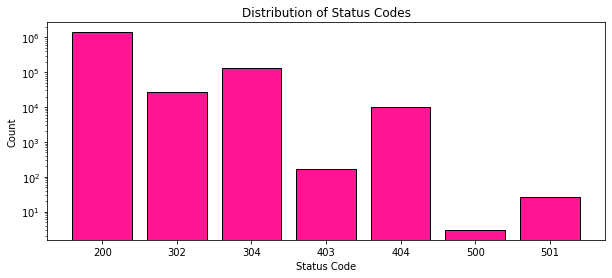

In [0]:
# empty list to hold code counts
code_counts = []

# count occurances of status codes
for code in status_codes:
  n = nasa.filter(lambda x : x[4] == code).count()
  # append to list
  code_counts.append(n)

# construct a bar chart
plt.figure(figsize = [10,4])
plt.bar(
  status_codes, 
  code_counts, 
  color='deeppink', 
  edgecolor='k'
)

# add labels
plt.title('Distribution of Status Codes')
plt.xlabel('Status Code')
plt.ylabel('Count')

# change y to log scale
plt.yscale('log')

# display chart
plt.show()

## Part G: Request Volume by Day
Determine the number of requests received by the server during each day in August 1995 and visualize the results.

In [0]:
# count # of requests for each day of Aug 1995
counts_by_day = (
  nasa
  # transform -> (day_of_month, 1)
  .map(lambda x : (x[1][1:3], 1))
  # transform -> (day_of_month, count_of_requests)
  .reduceByKey(lambda x,y : x + y)
  # sort by key values
  .sortBy(lambda x : x[0])
  # make list
  .collect()
)

# output first five elements
for row in counts_by_day[:5]:
  print(row)

('01', 33996)
('03', 41388)
('04', 59557)
('05', 31893)
('06', 32420)

Create a bar chart to display the distribution of requests by the day of the month.

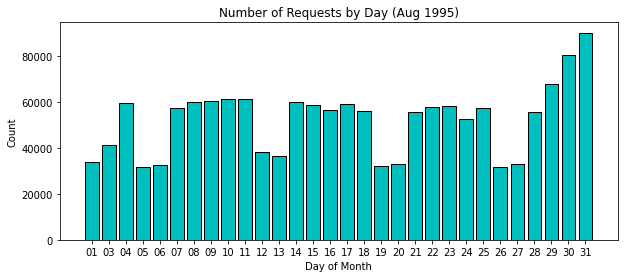

In [0]:
# split into two lists
day_list, count_list = zip(*counts_by_day)

# construct a bar chart
plt.figure(figsize = [10,4])
plt.bar(
  day_list, 
  count_list, 
  color='c', 
  edgecolor='k'
)

# add labels
plt.title('Number of Requests by Day (Aug 1995)')
plt.xlabel('Day of Month')
plt.ylabel('Count')

# display bar chart
plt.show()